In [36]:
import os
from argparse import ArgumentParser, Namespace
from typing import List

import torchvision
import umap
import yaml
from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.helper import load_maximization

from crp.visualization import FeatureVisualization
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from safetensors import safe_open
from scipy import stats
from sklearn.cluster import KMeans
from torchvision.utils import make_grid
from zennit.composites import EpsilonPlusFlat

from datasets import get_dataset
from models import get_canonizer, get_fn_model_loader
from utils.helper import get_layer_names_model
from utils.render import vis_opaque_img_border
import torch
import numpy as np
import matplotlib.pyplot as plt
import zennit.image as zimage

import warnings
warnings.filterwarnings("ignore")

import os
os.getcwd()

'/home/ttran02/pj/PURE'

In [37]:
import os
from argparse import ArgumentParser
import random
import numpy as np

from crp.attribution import CondAttribution
from crp.concepts import ChannelConcept
from crp.image import *
from crp.visualization import FeatureVisualization
from zennit.composites import EpsilonPlusFlat

from datasets import get_dataset
from models import get_fn_model_loader, get_canonizer
from models.timm_resnet_detection import get_resnet_timm, get_resnet50_timm, get_resnet34_timm, get_resnet101_timm, get_resnet_canonizer
from utils.helper import load_config, get_layer_names_model
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

import torch
import torch.nn as nn
import torch.nn.functional as F

import os
import pandas as pd
import numpy as np
import re
from sklearn.utils import resample
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import resource

import torch
from torch.utils.data import Dataset
import pandas as pd
import os
from PIL import Image
import re
from pathlib import Path
import numpy as np
import torchvision.transforms 
import torchvision.transforms.functional 

rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (2048, rlimit[1]))

database_path = '/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/'
target_classes = ['go', 'stop', 'warning','background']
color_map = {'go':'green', 'stop':'red', 'warning':'yellow','background':'gray'}
# rgb_color_map = {'go': (0, 255, 0), 'stop': (255, 0, 0), 'warning': (255, 255, 0)}

train_folder_list = [
    'dayTrain',
#     'daySequence1',
#     'daySequence2',
#     'sample-dayClip6',
#     'nightTrain',
#     'nightSequence1',
#     'nightSequence2',
#     'sample-nightClip1',
]

n_samples_per_class = 5000


MODELS = {
    "resnet50_timm": get_resnet50_timm,
    "resnet34_timm": get_resnet34_timm,
    "resnet101_timm": get_resnet101_timm,
}

CANONIZERS = {
    "resnet50_timm": get_resnet_canonizer,
    "resnet34_timm": get_resnet_canonizer,
    "resnet101_timm": get_resnet_canonizer,
}


def get_canonizer(model_name):
    assert model_name in list(CANONIZERS.keys()), f"No canonizer for model '{model_name}' available"
    return [CANONIZERS[model_name]()]


def get_fn_model_loader(model_name: str) -> torch.nn.Module:
    if model_name in MODELS:
        fn_model_loader = MODELS[model_name]
        return fn_model_loader
    else:
        raise KeyError(f"Model {model_name} not available")

def split_dataframe(df, test_size=0.2, random_state=42):
    """
    Split a dataframe into train and test sets
    
    Args:
        df (pd.DataFrame): Input dataframe
        test_size (float): Proportion of dataset to include in the test split
        random_state (int): Random state for reproducibility
    
    Returns:
        train_df, test_df (tuple of pd.DataFrame)
    """
    
    # Get indices for train and test sets
    train_idx, test_idx = train_test_split(
        df.index,
        test_size=test_size,
        random_state=random_state,
        shuffle=True
    )
    
    # Split the dataframe
    train_df = df.loc[train_idx].reset_index(drop=True)
    test_df = df.loc[test_idx].reset_index(drop=True)
    
    # Print split information
    print(f"Total samples: {len(df)}")
    print(f"Training samples: {len(train_df)} ({len(train_df)/len(df)*100:.1f}%)")
    print(f"Test samples: {len(test_df)} ({len(test_df)/len(df)*100:.1f}%)")
    
    return train_df, test_df

def get_annotarion_dataframe(train_data_folders):
    data_base_path = '/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/'
    annotation_list = list()
    for folder in [folder + '/' for folder in train_data_folders if os.listdir(data_base_path)]:
        annotation_path = ''
        if 'sample' not in folder:
            annotation_path = data_base_path + 'Annotations/Annotations/' + folder
        else:
            annotation_path = data_base_path + folder*2
        image_frame_path = data_base_path + folder*2
        
        df = pd.DataFrame()
        if 'Clip' in os.listdir(annotation_path)[0]:
            clip_list = os.listdir(annotation_path)
            for clip_folder in clip_list:
                df = pd.read_csv(annotation_path + clip_folder +  '/frameAnnotationsBOX.csv', sep=";")
                df['image_path'] = image_frame_path + clip_folder + '/frames/'
                annotation_list.append(df)
        else:
            df = pd.read_csv(annotation_path +  'frameAnnotationsBOX.csv', sep=";")
            df['image_path'] = image_frame_path + 'frames/'
            annotation_list.append(df)
        
    df = pd.concat(annotation_list)
    df = df.drop(['Origin file', 'Origin frame number', 'Origin track', 'Origin track frame number'], axis=1)
    df.columns = ['filename', 'target', 'x1', 'y1', 'x2', 'y2', 'image_path']
    df = df[df['target'].isin(target_classes)]
    df['filename'] = df['filename'].apply(lambda filename: re.findall("\/([\d\w-]*.jpg)", filename)[0])
    df = df.drop_duplicates().reset_index(drop=True)
    return df    

class TrafficLightDataset(Dataset):
    def __init__(self, df, img_dir, target_size=(64,64), transform=None, 
                 scaling_factor=4):
        """
        Args:
            df: DataFrame with traffic light annotations
            img_dir: Directory containing all images
            target_size: Tuple of (height, width) for resizing
            transform: Optional additional transforms to be applied after resizing
        """
        self.df = df
        self.img_dir = Path(img_dir)
        self.target_size = target_size 
        self.scaling_factor = scaling_factor
        self.additional_transform = transform
        
        # Group annotations by filename
        self.grouped_annotations = df.groupby('filename')
        
        # Get all unique filenames with annotations
        self.frames = list(set(df['filename'].unique()))
        
        # Label mapping
        self.label_map = {'background': 0, 'stop': 1, 'go': 2, 'warning': 3}
        
    def _resize_image_and_boxes(self, image, boxes):
        """
        Resize image and adjust bounding boxes accordingly
        """
        # Get original size
        orig_w, orig_h = image.size
#         print("sf, w, h", self.scaling_factor, orig_w, orig_h)
        target_h, target_w = (orig_w // self.scaling_factor, orig_h // self.scaling_factor) \
                                    if self.scaling_factor else self.target_size
        self.target_size = target_h, target_w
#         print("w, h", target_h, target_w)
        
        # Compute scaling factors
        w_scale = target_w / orig_w
        h_scale = target_h / orig_h
        
        # Resize image
        image = torchvision.transforms.functional.resize(image, self.target_size)
        
        if len(boxes):
            # Scale bounding boxes
            scaled_boxes = boxes.clone()
            scaled_boxes[:, [0, 2]] *= w_scale  # scale x coordinates
            scaled_boxes[:, [1, 3]] *= h_scale  # scale y coordinates
            
            # Clamp boxes to image boundaries
            scaled_boxes[:, [0, 2]] = torch.clamp(scaled_boxes[:, [0, 2]], 0, target_w)
            scaled_boxes[:, [1, 3]] = torch.clamp(scaled_boxes[:, [1, 3]], 0, target_h)
            
            return image, scaled_boxes
        
        return image, boxes
    
    def _get_boxes_and_labels(self, filename):
        """Get all bounding boxes and labels for a given image"""
        annotations = self.grouped_annotations.get_group(filename)
        boxes = torch.tensor([[row.x1, row.y1, row.x2, row.y2] 
                            for _, row in annotations.iterrows()], dtype=torch.float32)
        
        labels = torch.tensor([self.label_map[label] for label in annotations['target']], 
                            dtype=torch.long)
        
        return boxes, labels
    
    def _validate_boxes(self, boxes):
        """Remove invalid boxes (those with zero width or height after resizing)"""
        if len(boxes) == 0:
            return boxes, torch.zeros(0, dtype=torch.long)
        
        widths = boxes[:, 2] - boxes[:, 0]
        heights = boxes[:, 3] - boxes[:, 1]
        valid_boxes = (widths > 1) & (heights > 1)
        
        return boxes[valid_boxes], valid_boxes
    
    def __len__(self):
        return len(self.frames)
    
    def __getitem__(self, idx):
        filename = self.frames[idx]
        
        # Load image
        clip_name = filename.split('--')[0]
        img_path = self.img_dir / clip_name / "frames" / filename
        image = Image.open(img_path).convert('RGB')
        
        # Get original boxes and labels
        boxes, labels = self._get_boxes_and_labels(filename)
        
        # Resize image and adjust boxes
        image, boxes = self._resize_image_and_boxes(image, boxes)
        
        # Validate boxes after resizing
        boxes, valid_indices = self._validate_boxes(boxes)
        if len(valid_indices) < len(labels):
            labels = labels[valid_indices]
            
#         image = np.array(image)
        
        # Apply any additional transforms
        if self.additional_transform:
            image = self.additional_transform(image)
        
        # Convert PIL to tensor if not done by transforms
        if isinstance(image, Image.Image):
            image = torchvision.transforms.functional.to_tensor(image)
        
        # Create target dictionary
#         target = {
#             'boxes': boxes,
#             'labels': labels,
#             'image_id': torch.tensor([idx]),
#             'area': (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]),
#             'iscrowd': torch.zeros((len(boxes),), dtype=torch.int64),
#             'filename': filename,
#         }
        target = labels[-1].item()
        
        return image, target


# Example transforms
def get_transforms(train=True):
    from torchvision import transforms
    
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(0.5),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])
    else:
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ])

# Set random seeds for reproducibility
torch.manual_seed(42)
torch.cuda.manual_seed(42)
np.random.seed(42)


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def get_args():
    parser = ArgumentParser()
    parser.add_argument("--config_file", default="configs/imagenet/resnet101_timm.yaml")
    parser.add_argument('--split', type=str, default="test")
    parser.add_argument('--ckpt_path', type=str, default=None)
    return parser.parse_args()

import torch
from PIL import ImageFilter, Image, ImageDraw
from crp.image import get_crop_range, imgify
from torchvision.transforms.functional import gaussian_blur
from zennit.core import stabilize
from utils.render import mystroke


@torch.no_grad()
def vis_opaque_img_border(data_batch, heatmaps, rf=False, alpha=0.4, vis_th=0.02, crop_th=0.01,
                          kernel_size=51) -> Image.Image:
    """
    Draws reference images. The function lowers the opacity in regions with relevance lower than max(relevance)*vis_th.
    In addition, the reference image can be cropped where relevance is less than max(relevance)*crop_th by setting 'rf' to True.

    Parameters:
    ----------
    data_batch: torch.Tensor
        original images from dataset without FeatureVisualization.preprocess() applied to it
    heatmaps: torch.Tensor
        ouput heatmap tensor of the CondAttribution call
    rf: boolean
        Computes the CRP heatmap for a single neuron and hence restricts the heatmap to the receptive field.
        The amount of cropping is further specified by the 'crop_th' argument.
    alpha: between [0 and 1]
        Regulates the transparency in low relevance regions.
    vis_th: between [0 and 1)
        Visualization Threshold: Increases transparency in regions where relevance is smaller than max(relevance)*vis_th.
    crop_th: between [0 and 1)
        Cropping Threshold: Crops the image in regions where relevance is smaller than max(relevance)*crop_th.
        Cropping is only applied, if receptive field 'rf' is set to True.
    kernel_size: scalar
        Parameter of the torchvision.transforms.functional.gaussian_blur function used to smooth the CRP heatmap.

    Returns:
    --------
    image: list of PIL.Image objects
        If 'rf' is True, reference images have different shapes.

    """

    if alpha > 1 or alpha < 0:
        raise ValueError("'alpha' must be between [0, 1]")
    if vis_th >= 1 or vis_th < 0:
        raise ValueError("'vis_th' must be between [0, 1)")
    if crop_th >= 1 or crop_th < 0:
        raise ValueError("'crop_th' must be between [0, 1)")

    imgs = []
    heats = []
    for i in range(len(data_batch)):

        img = data_batch[i]

        filtered_heat = gaussian_blur(heatmaps[i].unsqueeze(0), kernel_size=kernel_size)[0]
        filtered_heat = filtered_heat.abs() / (filtered_heat.abs().max() + 1e-8)
        vis_mask = filtered_heat > vis_th
        # imgs.append(imgify(img.detach().cpu()).convert('RGB'))
        # continue
        if True:
            row1, row2, col1, col2 = get_crop_range(filtered_heat, crop_th)

            dr = row2 - row1
            dc = col2 - col1
            if dr > dc:
                col1 -= (dr - dc) // 2
                col2 += (dr - dc) // 2
                if col1 < 0:
                    col2 -= col1
                    col1 = 0
            elif dc > dr:
                row1 -= (dc - dr) // 2
                row2 += (dc - dr) // 2
                if row1 < 0:
                    row2 -= row1
                    row1 = 0

            img_t = img[..., row1:row2, col1:col2]
            vis_mask_t = vis_mask[row1:row2, col1:col2]

            if img_t.sum() != 0 and vis_mask_t.sum() != 0:
                # check whether img_t or vis_mask_t is not empty
                img = img_t
                vis_mask = vis_mask_t

        inv_mask = ~vis_mask
        outside = (img * vis_mask).sum((1, 2)).mean(0) / stabilize(vis_mask.sum()) > 0.5

        img = img * vis_mask + img * inv_mask * alpha + outside * 0 * inv_mask * (1 - alpha)

        img = imgify(img.detach().cpu()).convert('RGBA')

        img_ = np.array(img).copy()
        img_[..., 3] = (vis_mask * 255).detach().cpu().numpy().astype(np.uint8)
        img_ = mystroke(Image.fromarray(img_), 1, color='black' if outside else 'black')

        img.paste(img_, (0, 0), img_)

        imgs.append(img.convert('RGB'))
        
        heat = heatmaps[i].detach().cpu()
        heat = imgify(heat, cmap="bwr", symmetric=True)
        heats.append(heat)

    return imgs, heats



In [38]:



def get_parser(fixed_arguments: List[str] = []):
#     parser = ArgumentParser(
#         description='Compute and display the top-k most relevant neurons for a given data sample/prediction.', )

#     parser.add_argument('--config_file',
#                         default="configs/imagenet/resnet50_timm.yaml")
#     parser.add_argument('--neurons',
#                         default="1,2,3,4,5")
#     parser.add_argument('--embeddings',
#                         default="pure") # "pure", "CLIP", "activations"
#     args = parser.parse_args()
    args = Namespace(
        config_file="configs/imagenet/resnet34_timm.yaml",
        neurons="1,2,3,4,5",
        embeddings="pure" # "pure", "CLIP", "activations"
    )

    with open(args.config_file, "r") as stream:
        try:
            config = yaml.safe_load(stream)
            config["config_name"] = os.path.basename(args.config_file)[:-5]
        except yaml.YAMLError as exc:
            print(exc)
            config = {}

    for k, v in config.items():
        if k not in fixed_arguments:
            setattr(args, k, v)

    return args


args = get_parser()
model_name = args.model_name
dataset_name = args.dataset_name

SPLIT = "train"
split = SPLIT


device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_workers = 4
batch_size = 32

train_annotation_df = get_annotarion_dataframe(train_folder_list)

clips = {}
img_dir = Path(os.path.join(database_path, 'dayTrain/dayTrain'))
print(img_dir)

# Walk through all clip directories
for clip_dir in img_dir.glob('dayClip*/frames'):
    # Extract clip name from path
    clip_name = clip_dir.parents[0].name + '--'  # e.g., 'dayClip13--'

    # Get all image files in frames directory
    frame_files = [f for f in clip_dir.glob('*.jpg')]

    # Extract frame numbers
    for frame_path in frame_files:
        # Extract frame number from filename (e.g., '00000' from 'dayClip13--00000.jpg')
        frame_num = int(frame_path.stem.split('--')[-1])

        if clip_name.strip('-') not in clips:
            clips[clip_name.strip('-')] = set()
        clips[clip_name.strip('-')].add(frame_num)

positive_frames = set(train_annotation_df['filename'].unique())
for clip_name, frame_nums in clips.items():
    for frame_num in frame_nums:
        filename = f"{clip_name}--{frame_num:05d}.jpg"
        if filename not in positive_frames:
            train_annotation_df = pd.concat([pd.DataFrame([[filename,'background', 0,0,0,0,f"{img_dir}/{clip_name}/frames/{filename}"]], 
                                                          columns=train_annotation_df.columns), 
                                             train_annotation_df], 
                                            ignore_index=True)

target_classes = train_annotation_df['target'].unique()
target_classes.sort()

def resample_dataset(annotation_df, n_samples):
    df_resample_list = list()
    for target in target_classes:
        df = annotation_df[annotation_df['target'] == target].copy()
        df_r = resample(df, n_samples=n_samples, random_state=42)
        df_resample_list.append(df_r)
    return pd.concat(df_resample_list).reset_index(drop=True)

train_annotation_df = resample_dataset(train_annotation_df, n_samples_per_class)
print(train_annotation_df['target'].value_counts())

train_df, test_df = split_dataframe(train_annotation_df, random_state=42)
train_df, val_df = split_dataframe(train_df, random_state=420)

if split == "train":
    df = train_df
    transforms_ = get_transforms(train=True)
elif split == "val":
    df = val_df
    transforms_ = get_transforms(train=False)
else:
    df = test_df
    transforms_ = get_transforms(train=False)

dataset = TrafficLightDataset(
    df=df,
    img_dir='/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain',
    transform=transforms_
)

model = get_fn_model_loader(model_name)(n_class=4, ckpt_path=args.ckpt_path).to(device)
model.load_state_dict(torch.load('best_model.pth'))

original_forward = model.forward

def new_forward(self, x: torch.Tensor) -> torch.Tensor:
    # Get original outputs using the stored forward method
    cls_scores, _ = original_forward(x)

    # cls_scores shape: (batch_size, num_anchors, num_classes + 1, H, W)
    batch_size, num_anchors, num_classes, H, W = cls_scores.shape

    # Apply softmax along the classes dimension to get probabilities
    cls_probs = torch.softmax(cls_scores, dim=2)

    # Sum the probabilities for traffic light classes (labels 1, 2, 3 for stop, go, warning)
    # Exclude background class (label 0)
    traffic_light_probs = cls_probs[:, :, 1:, :, :].sum(dim=2)  # (batch_size, num_anchors, H, W)

    # Find the anchor with highest traffic light probability for each spatial location
    best_anchor_scores, best_anchor_indices = traffic_light_probs.max(dim=1)  # (batch_size, H, W)

    return cls_scores[:, best_anchor_indices, :, :, :]

# Bind the new forward method to the model
model.forward = new_forward.__get__(model)
model.eval()


batch_size = 100
n_refimgs = 20
mode = "relevance" #"activation" "relevance"



canonizers = get_canonizer(model_name)
composite = EpsilonPlusFlat(canonizers)
cc = ChannelConcept()

layer_names = get_layer_names_model(model, model_name)
layer_map = {layer: cc for layer in layer_names}

print(layer_names)
layer_name = layer_names[-1]

attribution = CondAttribution(model)

from torchvision import transforms
fv_name = f"crp_files/{model_name}_{dataset_name}_{SPLIT}"
fv = FeatureVisualization(attribution, dataset, layer_map, preprocess_fn=transforms.Compose([
            transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                              std=[0.229, 0.224, 0.225])
        ]),
                          path=fv_name, max_target="max", abs_norm=False)

if not os.listdir(fv.RelMax.PATH):
    fv.run(composite, 0, len(dataset), batch_size=batch_size)


d_c_sorted, a, rf_c_sorted = load_maximization(fv.ActMax.PATH, layer_name)


tensors = {}
path = f"results/global_features/{dataset_name}/{model_name}"

if args.embeddings == "pure":
    with safe_open(f"{path}/latent_features_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
       for key in f.keys():
           tensors[key] = f.get_tensor(key)
    embeddings = tensors["cond_rel"][:, :n_refimgs]
# elif args.embeddings == "CLIP":
#     with safe_open(f"{path}/latent_embeddings_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
#         for key in f.keys():
#             tensors[key] = f.get_tensor(key)
#     embeddings = tensors["CLIP"][:, :n_refimgs]
# elif args.embeddings == "activations":
#     with safe_open(f"{path}/latent_features_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
#         for key in f.keys():
#             tensors[key] = f.get_tensor(key)
#     embeddings = tensors["mean_act"][:, :n_refimgs]


n_clusters = 2

neurons = torch.tensor([int(i) for i in args.neurons.split(",")])


/home/ttran02/.cache/kagglehub/datasets/mbornoe/lisa-traffic-light-dataset/versions/2/dayTrain/dayTrain
target
background    5000
go            5000
stop          5000
warning       5000
Name: count, dtype: int64
Total samples: 20000
Training samples: 16000 (80.0%)
Test samples: 4000 (20.0%)
Total samples: 16000
Training samples: 12800 (80.0%)
Test samples: 3200 (20.0%)
before detection head: 21286724
after detection head: 23657816
['block_0', 'block_1', 'block_2', 'block_3']


In [50]:
import warnings
from crp.image import vis_opaque_img
warnings.filterwarnings("ignore")

def make_grid_1channel(images, nrow):
    """
    Create a grid of images while preserving single channel.
    
    Args:
        images: List of numpy arrays or torch tensors, each of shape (1, H, W) or (H, W)
        nrow: Number of images per row
    
    Returns:
        numpy array of shape (H, W * nrow)
    """
    # Convert to numpy if needed and ensure consistent shape
    imgs = []
    for img in images:
        if torch.is_tensor(img):
            img = img.cpu().numpy()
        # Remove single channel dimension if present
        if img.shape[0] == 1 and len(img.shape) == 3:
            img = img.squeeze(0)
        imgs.append(img)
    
    # Verify all images have same shape
    if not all(img.shape == imgs[0].shape for img in imgs):
        raise ValueError("All images must have the same shape")
    
    n = len(imgs)
    if n > nrow:
        ncol = (n + nrow - 1) // nrow  # Ceiling division
    else:
        ncol = 1
        nrow = n
    
    h, w = imgs[0].shape
    grid = np.zeros((h * ncol, w * nrow), dtype=imgs[0].dtype)
    
    for idx, img in enumerate(imgs):
        i = idx // nrow
        j = idx % nrow
        grid[i * h:(i + 1) * h, j * w:(j + 1) * w] = img
    
    return grid

n_clusters = 3
neurons = torch.tensor(range(4))

# for inds_ in [torch.tensor(range(i*8,i*8+8)) for i in range(64)]:
for inds_ in [neurons]:
    fig, axs = plt.subplots(2 + 2*n_clusters, len(neurons), dpi=500, figsize=(len(neurons) * 2 * 4/1.3, 2 * 6/1.4),
                            gridspec_kw={'height_ratios': [len(neurons)*2, 1, *np.ones(n_clusters*2).tolist()]},)
    for i, inds in enumerate(inds_):
        print(inds)
        ref_imgs = fv.get_max_reference([inds.item()], layer_name, mode, (0, n_refimgs),
                                        composite=composite, 
#                                         rf=True, 
                                        batch_size=n_refimgs,
                                        plot_fn=vis_opaque_img_border,
#                                         plot_fn=vis_opaque_img,
#                                         plot_fn=None,
                                       )
        
        heatmaps = {x:ref_imgs[x][1] for x in ref_imgs}
        ref_imgs = {x:ref_imgs[x][0] for x in ref_imgs}
        
        embedding = umap.UMAP(n_neighbors=6, min_dist=0.3, spread=1.0)
        X = embedding.fit_transform(embeddings[inds])
        x, y = X[:, 0], X[:, 1]
        xmin = x.min() - 0.2 * (x.max() - x.min())
        xmax = x.max() + 0.2 * (x.max() - x.min())
        ymin = y.min() - 0.2 * (y.max() - y.min())
        ymax = y.max() + 0.2 * (y.max() - y.min())
        X, Y = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
        positions = np.vstack([X.ravel(), Y.ravel()])
        values = np.vstack([x, y])
        kernel = stats.gaussian_kde(values, 0.5)
        Z = np.reshape(kernel(positions).T, X.shape).T
        axs[0][i].contour(Z, extent=[xmin, xmax, ymin, ymax], cmap="Greys", alpha=0.3, extend='min', vmax=Z.max() * 1, zorder=0)
        axs[0][i].scatter(x, y, alpha=0.7, c="black", s=10)

        for j, img_ in enumerate(ref_imgs[inds.item()]):
            imagebox = OffsetImage(img_.resize((100, 100)), zoom=0.15)
            ab = AnnotationBbox(imagebox, (x[j], y[j]), frameon=True, pad=0)
            axs[0][i].add_artist(ab)

        axs[0][i].set_xticks([])
        axs[0][i].set_yticks([])
        axs[0][i].text(0.02, 0.98, f'#{inds.item()}', ha='left', va='top', transform=axs[0][i].transAxes)

        resize = torchvision.transforms.Resize((150, 150))

        NUM = 8
        ref_imgs_ = ref_imgs[inds.item()]
        grid = make_grid(
            [resize(torch.from_numpy(np.asarray(k)).permute((2, 0, 1))) for k in ref_imgs_[:NUM]],
            nrow=NUM,
            padding=0)
        grid = np.array(zimage.imgify(grid.detach().cpu()))
        axs[1][i].imshow(grid)
        axs[1][i].set_xticks([])
        axs[1][i].set_yticks([])
        axs[1][i].set_ylabel("all") if i == 0 else None

    
        heatmaps_ = heatmaps[inds.item()]
        cluster = KMeans(n_clusters=n_clusters, n_init=20, random_state=123).fit(embeddings[inds])
        labels = np.array(cluster.labels_)
        for lab in np.unique(labels):
            ref_imgs_cluster = [r for k, r in enumerate(ref_imgs_) if labels[k] == lab]
            grid = make_grid(
                [resize(torch.from_numpy(np.asarray(k)).permute((2, 0, 1))) for k in ref_imgs_cluster[:NUM]],
                nrow=NUM,
                padding=0)
#             print(grid.shape)
            grid = np.array(zimage.imgify(grid.detach().cpu()))
            axs[2 + 2*lab][i].imshow(grid)
            axs[2 + 2*lab][i].set_xticks([])
            axs[2 + 2*lab][i].set_yticks([])
            axs[2 + 2*lab][i].set_ylabel(f"{lab + 1}") if i == 0 else None
           
            
            heatmaps_cluster = [r for k, r in enumerate(heatmaps_) if labels[k] == lab]
#             print(len(heatmaps_cluster))
#             if len(heatmaps_cluster) > 3:
#                 raise
#             grid = make_grid(
#                 [resize(torch.from_numpy(np.asarray(k)).unsqueeze(0)) for k in heatmaps_cluster[:NUM]],
#                 nrow=NUM,
#                 normalize=False,
#                 padding=0)
            grid = make_grid_1channel(
                [resize(torch.from_numpy(np.asarray(k)).unsqueeze(0)) for k in heatmaps_cluster[:NUM]],
                NUM
            )
#             print(grid.shape)
            grid = imgify(grid)
#             grid = imgify(np.array(grid.detach().cpu()))
#             grid = resize(torch.from_numpy(np.asarray(heatmaps_cluster[0])).unsqueeze(0)).squeeze(0)
#             grid = np.asarray(heatmaps_cluster[0])
            
            axs[2 + 2*lab + 1][i].imshow(grid)
            axs[2 + 2*lab + 1][i].set_xticks([])
            axs[2 + 2*lab + 1][i].set_yticks([])
#             axs[2 + 2*lab + 1][i].set_ylabel(f"{lab + 1}") if i == 0 else None

    plt.tight_layout()

    path = f"results/neuron_plots/{dataset_name}/{model_name}"
    os.makedirs(path, exist_ok=True)
    plt.savefig(f"{path}/channels_{'_'.join([str(n.item()) for n in inds_])}.pdf", dpi=500)
    plt.close()
#     plt.show()


tensor(0)
tensor(1)
tensor(2)
tensor(3)


In [40]:
labels, lab

(array([0, 1, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 2, 0, 1, 0, 0, 1, 1, 0],
       dtype=int32),
 2)

In [41]:
resize(torch.from_numpy(np.asarray(heatmaps_cluster[0])).unsqueeze(0)).shape

torch.Size([1, 150, 150])

In [42]:
temp = [resize(torch.from_numpy(np.asarray(k)).unsqueeze(0)) for k in heatmaps_cluster[:NUM]]
print([x.shape for x in temp])
grid = make_grid(
                temp,
                nrow=NUM,
                padding=0)
grid.shape, NUM

[torch.Size([1, 150, 150]), torch.Size([1, 150, 150])]


(torch.Size([3, 150, 300]), 8)

In [43]:
heatmaps_cluster

[<PIL.Image.Image image mode=P size=240x320>,
 <PIL.Image.Image image mode=P size=240x320>]

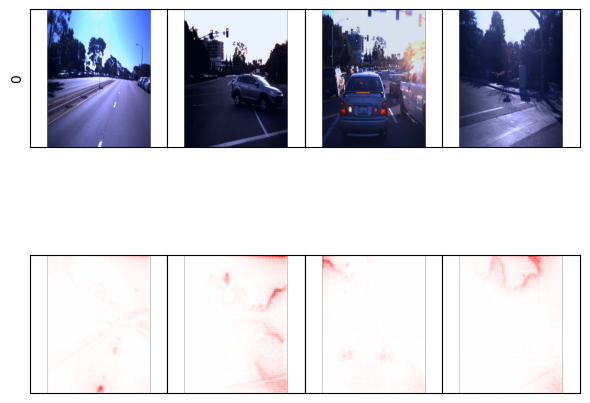

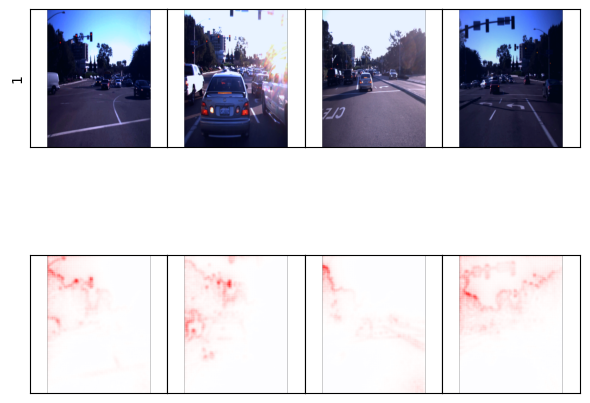

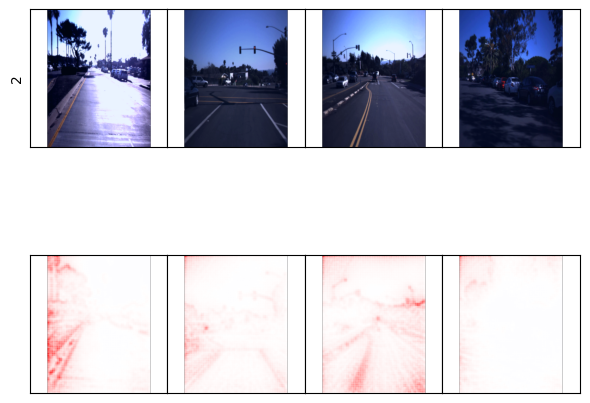

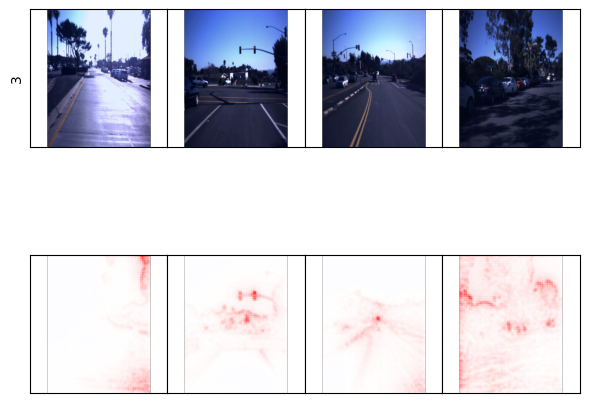

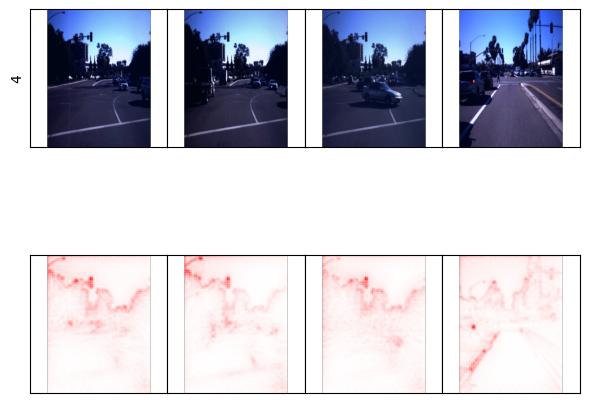

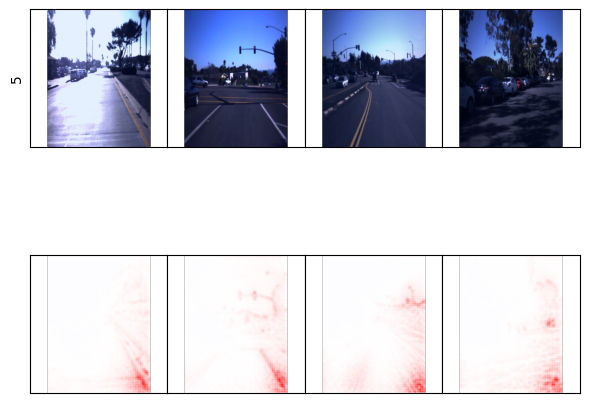

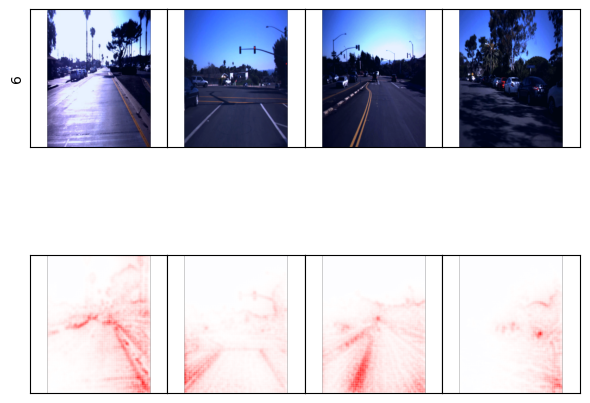

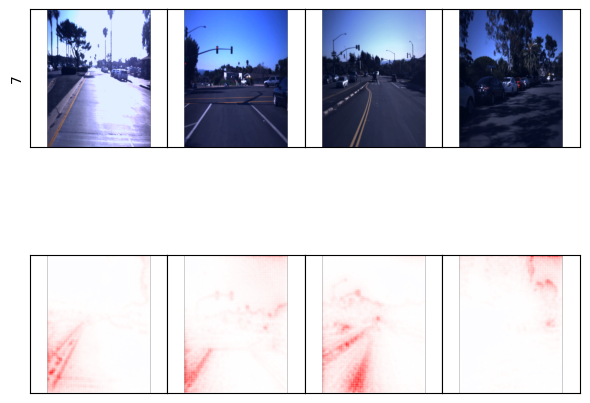

In [44]:
from crp.image import plot_grid

def plot_grid(ref_c: Dict[int, Any], cmap_dim=1, cmap="bwr", vmin=None, vmax=None, symmetric=True, resize=None, padding=True, figsize=(6, 6)):
    """
    Plots dictionary of reference images as they are returned of the 'get_max_reference' method. To every element in the list crp.imgify is applied with its respective argument values.

    Parameters:
    ----------
    ref_c: dict with keys: integer and value: several lists filled with torch.Tensor, np.ndarray or PIL Image
        To every element in the list crp.imgify is applied.
    resize: None or int
        If None, no resizing is applied. If int, sets the maximal aspect ratio of the image.
    padding: boolean
        If True, pads the image into a square shape by setting the alpha channel to zero outside the image.
    figsize: tuple or None
        Size of plt.figure
    cmap_dim: int, 0 or 1 
        Applies the remaining parameters to the first or second element of the tuple list, i.e. plot as heatmap

    REMAINING PARAMETERS: correspond to zennit.imgify

    Returns:
    --------
    shows matplotlib.pyplot plot
    """

    keys = list(ref_c.keys())
    nrows = len(keys)
    value = next(iter(ref_c.values()))
    temp = None

    if cmap_dim > 2 or cmap_dim < 1 or cmap_dim == None:
        raise ValueError("'cmap_dim' must be 0 or 1 or None.")

    if isinstance(value, Tuple) and isinstance(value[0], Iterable):
        nsubrows = len(value)
        ncols = len(value[0])
    elif isinstance(value, Iterable):
        nsubrows = 1
        ncols = len(value)
    else:
        raise ValueError("'ref_c' dictionary must contain an iterable of torch.Tensor, np.ndarray or PIL Image or a tuple of thereof.")

    fig = plt.figure(figsize=figsize)
    outer = gridspec.GridSpec(nrows, 1, wspace=0, hspace=0.2)

    for i in range(nrows):
        inner = gridspec.GridSpecFromSubplotSpec(nsubrows, ncols, subplot_spec=outer[i], wspace=0, hspace=0.1)

        for sr in range(nsubrows):

            if nsubrows > 1:
                img_list = ref_c[keys[i]][sr]
            else:
                img_list = ref_c[keys[i]]
            
            for c in range(ncols):
                ax = plt.Subplot(fig, inner[sr, c])
                
                
                
                if sr == cmap_dim:
                    img = imgify(img_list[c], cmap=cmap, vmin=vmin, vmax=vmax, symmetric=symmetric, resize=resize, padding=padding)
                else:
                    img = imgify(img_list[c], resize=resize, padding=padding)
                    
                if len(img_list[c].shape) == 2:
                    temp = img

                ax.imshow(img)
                ax.set_xticks([])
                ax.set_yticks([])

                if sr == 0 and c == 0:
                    ax.set_ylabel(keys[i])

                fig.add_subplot(ax)
                
    outer.tight_layout(fig)  
    fig.show()
    plt.show()

neurons = torch.tensor(range(8)) #512
for inds_ in [neurons]:
#     fig, axs = plt.subplots(2 + n_clusters, len(neurons), dpi=300, figsize=(len(neurons) * 4/1.3, 6/1.4),
#                             gridspec_kw={'height_ratios': [len(neurons), 1, *np.ones(n_clusters).tolist()]},)
    for i, inds in enumerate(inds_):
#         print(i)
#         ref_imgs = fv.get_max_reference([inds.item()], layer_name, mode, (0, 4),
#                                         composite=composite, rf=True, batch_size=n_refimgs,
# #                                         plot_fn=vis_opaque_img_border,
# #                                         plot_fn=vis_opaque_img,
#                                         plot_fn=None,
#                                        )
        ref_imgs = fv.get_max_reference([inds.item()], layer_name, "relevance", (0, 4),
                                        composite=composite, 
                                        plot_fn=None,
#                                         rf=True,
                                       )
        plot_grid(ref_imgs, figsize=(6, 5))

In [10]:
ref_imgs[7][0][0].shape

torch.Size([3, 320, 240])

In [16]:
layer_names

['conv1',
 'layer1.0.conv1',
 'layer1.0.conv2',
 'layer1.1.conv1',
 'layer1.1.conv2',
 'layer1.2.conv1',
 'layer1.2.conv2',
 'layer2.0.conv1',
 'layer2.0.conv2',
 'layer2.0.downsample.0',
 'layer2.1.conv1',
 'layer2.1.conv2',
 'layer2.2.conv1',
 'layer2.2.conv2',
 'layer2.3.conv1',
 'layer2.3.conv2',
 'layer3.0.conv1',
 'layer3.0.conv2',
 'layer3.0.downsample.0',
 'layer3.1.conv1',
 'layer3.1.conv2',
 'layer3.2.conv1',
 'layer3.2.conv2',
 'layer3.3.conv1',
 'layer3.3.conv2',
 'layer3.4.conv1',
 'layer3.4.conv2',
 'layer3.5.conv1',
 'layer3.5.conv2',
 'layer4.0.conv1',
 'layer4.0.conv2',
 'layer4.0.downsample.0',
 'layer4.1.conv1',
 'layer4.1.conv2',
 'layer4.2.conv1',
 'layer4.2.conv2',
 'detection_head.conv_shared.0',
 'detection_head.conv_cls',
 'detection_head.conv_bbox']

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.6813945].


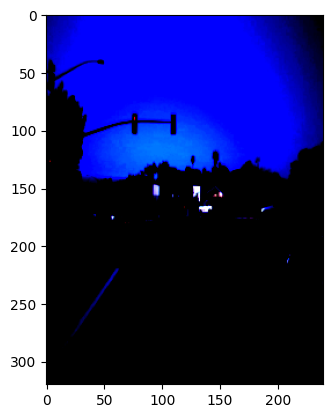

In [34]:
plt.imshow(sample.detach().cpu()[1,:,:,:].permute(1,2,0))

In [35]:
from crp.attribution import AttributionGraph
from crp.graph import trace_model_graph
from crp.helper import get_layer_names

sample = ref_imgs[7][0].to(device)
sample.requires_grad = True

layer_names = get_layer_names(model, [torch.nn.Conv2d, torch.nn.Linear])[:-1]
layer_map = {name: cc for name in layer_names}
# layer_name = 'detection_head.conv_cls'
layer_name = 'layer4.2.conv2'

graph = trace_model_graph(model, sample, layer_names)
print(graph)



attgraph = AttributionGraph(attribution, graph, layer_map)

nodes, connections = attgraph(sample, composite, 1, layer_name, 1, width=[5, 2], abs_norm=True)
print("Nodes:\n", nodes, "\nConnections:\n", connections)

> /home/ttran02/pj/PURE/crp/graph.py(181)trace_model_graph()
    179 
    180     # initialize a model representation where we save the results
--> 181     MG = ModelGraph(input_nodes)
    182 
    183     # start recursive decoding of torch.jit graph



ipdb>  c


__module.conv1 -> __module.bn1, 
__module.bn1 -> __module.act1, 
__module.act1 -> __module.maxpool, 
__module.maxpool -> __module.layer1/__module.layer1.0/__module.layer1.0.conv1, __module.layer1/__module.layer1.0, 
__module.layer1/__module.layer1.0/__module.layer1.0.conv1 -> __module.layer1/__module.layer1.0/__module.layer1.0.bn1, 
__module.layer1/__module.layer1.0/__module.layer1.0.bn1 -> __module.layer1/__module.layer1.0/__module.layer1.0.act1, 
__module.layer1/__module.layer1.0/__module.layer1.0.act1 -> __module.layer1/__module.layer1.0/__module.layer1.0.conv2, 
__module.layer1/__module.layer1.0/__module.layer1.0.conv2 -> __module.layer1/__module.layer1.0/__module.layer1.0.bn2, 
__module.layer1/__module.layer1.0/__module.layer1.0.bn2 -> __module.layer1/__module.layer1.0, 
__module.layer1/__module.layer1.0 -> __module.layer1/__module.layer1.0/__module.layer1.0.act2, 
__module.layer1/__module.layer1.0/__module.layer1.0.act2 -> __module.layer1/__module.layer1.1/__module.layer1.1.conv1

100%|███████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  6.74it/s]


Nodes:
 [('layer4.2.conv2', 1), ('layer4.2.conv1', 1), ('layer4.2.conv1', 4), ('layer4.2.conv1', 6), ('layer4.2.conv1', 10), ('layer4.2.conv1', 11), ('layer4.1.conv2', 417), ('layer4.1.conv2', 444), ('layer4.0.conv2', 10), ('layer4.0.conv2', 392), ('layer4.0.downsample.0', 10), ('layer4.0.downsample.0', 392), ('layer4.1.conv2', 417), ('layer4.1.conv2', 444), ('layer4.0.conv2', 10), ('layer4.0.conv2', 392), ('layer4.0.downsample.0', 10), ('layer4.0.downsample.0', 392), ('layer4.1.conv2', 417), ('layer4.1.conv2', 444), ('layer4.0.conv2', 10), ('layer4.0.conv2', 392), ('layer4.0.downsample.0', 10), ('layer4.0.downsample.0', 392), ('layer4.1.conv2', 417), ('layer4.1.conv2', 444), ('layer4.0.conv2', 10), ('layer4.0.conv2', 392), ('layer4.0.downsample.0', 10), ('layer4.0.downsample.0', 392), ('layer4.1.conv2', 417), ('layer4.1.conv2', 444), ('layer4.0.conv2', 10), ('layer4.0.conv2', 392), ('layer4.0.downsample.0', 10), ('layer4.0.downsample.0', 392)] 
Connections:
 {('layer4.2.conv2', 1): [(

In [22]:
graph.find_input_layers("layer4.2.conv2")

['layer4.2.conv1']

In [ ]:
layer_name

In [ ]:
ref_imgs[7]

In [ ]:
dataset_name = "imagenet"
model_name = "resnet34_timm"
SPLIT = "test"
layer_name = "block_3"

tensors = {}
path = f"results/global_features/{dataset_name}/{model_name}"
with safe_open(f"{path}/latent_embeddings_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
   for key in f.keys():
       tensors[key] = f.get_tensor(key)

M = 50    # number of reference samples
CLIP_embeddings = tensors["CLIP"][:, :M]
DINO_embeddings = tensors["DINO"][:, :M]

tensors = {}
path = f"results/global_features/{dataset_name}/{model_name}"
with safe_open(f"{path}/latent_features_{layer_name}_{SPLIT}.safetensors", framework="pt", device="cpu") as f:
    for key in f.keys():
        tensors[key] = f.get_tensor(key)

PURE_embeddings = tensors["cond_rel"][:, :M]
ACT_embeddings = tensors["mean_act"][:, :M]

In [ ]:
label = ["DINOv2", "PURE", "activations"]
X = [DINO_embeddings, PURE_embeddings, ACT_embeddings]
X_0 = CLIP_embeddings

n_subsets = 30
len_subset = X_0.shape[0] // n_subsets
random_indices = np.random.choice(X_0.shape[0], X_0.shape[0], replace=False)
subsets = [random_indices[(i)*len_subset:(i+1)*len_subset] for i in range(n_subsets)]

Y = [[] for x in X]

for k, subset in enumerate(subsets):
    x_0 = torch.norm(X_0[subset][:, None] - X_0[subset][:, :, None], dim=3).flatten()
    x_ = [
        torch.norm(x[subset][:, None] - x[subset][:, :, None], dim=3).flatten()
        for x in X
    ]
    
    for i, x in enumerate(x_):
        zeros = (x_0 * x) == 0
        dist_x = x[zeros == False]
        dist_x_0 = x_0[zeros == False]
        Y[i].append(np.corrcoef(dist_x_0, dist_x)[0, 1])
        

In [ ]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Roboto'
fig, ax = plt.subplots(1, 1, dpi=500, figsize=(2.5, 1.5)) 

correlations = [np.mean(y) for y in Y]
plt.bar(label, correlations, color="#0094FF")
plt.errorbar(np.arange(len(label)),
             [np.mean(y) for y in Y],
             yerr=[np.std(y)/np.sqrt(len(y)) for y in Y],
             color='k', fmt='.', elinewidth=0.1, capsize=5)
for i, m in enumerate(correlations):
    plt.text(i, m + 0.001, f"${m:.2f}$", ha="center", va="bottom")
plt.ylim(0, 0.7)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.ylabel("correlation with \nCLIP distances")
plt.yticks([])
plt.xlim(-0.5, len(correlations)-0.6)
plt.tight_layout()

plt.savefig(f"correlation_CLIP_{model_name}.svg", dpi=300)
plt.show()

In [ ]:
embeddings[inds].shape

In [ ]:
layer_names = get_layer_names_model(model, model_name)
layer_names

In [ ]:
dataset[10]